In [1]:
import pandas as pd

train_csv_path = '/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-image/train_labels.csv'
test_csv_path = '/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-image/test.csv'

train_dataset = '/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-image/train_test_data/train/'
test_dataset = '/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-image/train_test_data/test/'

train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

train['filename'] = train_dataset + train['filename']
test['filename'] = test_dataset + test['filename']

In [2]:
mapper = {name: i for i, name in enumerate(train['label'].unique())}
unmapper = {value: key for key, value in mapper.items()}
train['label'] = train['label'].map(mapper)
train

,filename,label
0,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,0
1,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,1
2,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,2
3,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,3
4,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,4
...,...,...
4768,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,143
4769,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,113
4770,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,4
4771,/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-im...,105


In [3]:
mapper

{'Koffing': 0,
 'Venonat': 1,
 'Nidoking': 2,
 'Victreebel': 3,
 'Persian': 4,
 'Ekans': 5,
 'Jigglypuff': 6,
 'Vulpix': 7,
 'Lickitung': 8,
 'Cloyster': 9,
 'Paras': 10,
 'Pidgeotto': 11,
 'Rapidash': 12,
 'Ditto': 13,
 'Clefairy': 14,
 'Charmander': 15,
 'Kakuna': 16,
 'Flareon': 17,
 'Charmeleon': 18,
 'Raichu': 19,
 'Seel': 20,
 'Omanyte': 21,
 'Machamp': 22,
 'Tauros': 23,
 'Primeape': 24,
 'Ponyta': 25,
 'Hitmonchan': 26,
 'Mankey': 27,
 'Electabuzz': 28,
 'Chansey': 29,
 'Hypno': 30,
 'Gloom': 31,
 'Nidoqueen': 32,
 'Vaporeon': 33,
 'Rattata': 34,
 'Metapod': 35,
 'Sandshrew': 36,
 'Kabuto': 37,
 'Eevee': 38,
 'Pinsir': 39,
 'Arbok': 40,
 'Kabutops': 41,
 'Seadra': 42,
 'Lapras': 43,
 'Arcanine': 44,
 'Poliwhirl': 45,
 'Gyarados': 46,
 'Jynx': 47,
 'Venusaur': 48,
 'Venomoth': 49,
 'Kadabra': 50,
 'Butterfree': 51,
 'Seaking': 52,
 'Tangela': 53,
 'Slowpoke': 54,
 'Growlithe': 55,
 'Marowak': 56,
 'Spearow': 57,
 'Electrode': 58,
 'Drowzee': 59,
 'Dewgong': 60,
 'Squirtle': 61,


In [3]:
import cv2
from tqdm import trange


train_images = []
for i in trange(len(train)):
    train_images.append(cv2.imread(train.iloc[i]['filename']))

100%|██████████| 4773/4773 [00:15<00:00, 300.56it/s]


In [23]:
import torch
from transformers import CLIPImageProcessor, CLIPModel


model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14")

train_inputs = processor(images=train_images, return_tensors="pt", padding=True)

with torch.no_grad():
    train_embeddings = model.get_image_features(**train_inputs).detach().numpy()

Unused or unrecognized kwargs: padding.


In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(train_embeddings)

In [25]:
X_tsne.shape

(4773, 2)

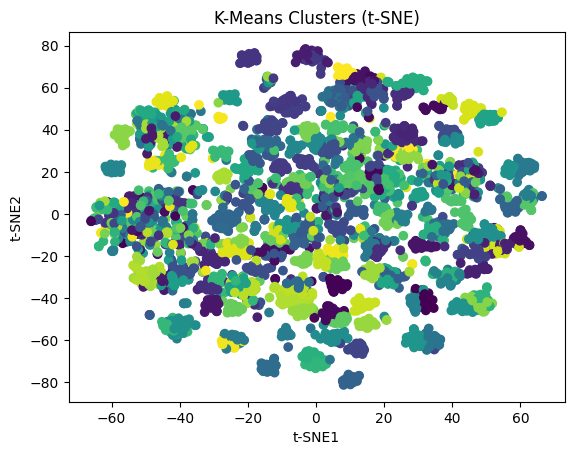

In [26]:
import matplotlib.pyplot as plt

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train['label'].values, cmap='viridis')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('K-Means Clusters (t-SNE)')
plt.show()

In [27]:
import cv2
from tqdm import trange


test_images = []
for i in trange(len(test)):
    test_images.append(cv2.imread(test.iloc[i]['filename']))

100%|██████████| 2046/2046 [00:06<00:00, 335.55it/s]


In [28]:
test_inputs = processor(images=test_images, return_tensors="pt", padding=True)
with torch.no_grad():
    test_embeddings = model.get_image_features(**test_inputs).detach().numpy()

Unused or unrecognized kwargs: padding.


In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings, train['label'])

KNeighborsClassifier(n_neighbors=3)

In [38]:
preds = knn.predict(test_embeddings)
preds

array([ 87, 108,  48, ...,   4, 107,  93])

In [44]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


preds = []
values = []
for i in trange(len(test_embeddings)):
    similarities = cosine_similarity([test_embeddings[i]], train_embeddings)
    best_match_index = np.argmax(similarities)
    best_match_value = np.max(similarities)
    train_path, predicted_class = train.iloc[best_match_index]
    
    cos = np.max(similarities)
    if cos > 0.8:
        train_image = train_images[best_match_index]
        train_image = cv2.resize(train_image, (224, 224))
        test_image = test_images[i]
        test_image = cv2.resize(test_image, (224, 224))
        concat_image = cv2.hconcat([train_image, test_image])
        train_name = train_path.split('/')[-1].split('.')[0]
        test_name = test.iloc[i]['filename'].split('/')[-1]
        class_name = unmapper[predicted_class]
        cv2.imwrite('/AkhmetzyanovD/projects/MTS/NN/contest_1/sim2/' + str(round(cos, 2)) + '__' + class_name + '__' + train_name + '__' + test_name, concat_image)

    values.append(best_match_value)
    preds.append(predicted_class)

100%|██████████| 2046/2046 [00:52<00:00, 38.88it/s]


In [45]:
values = np.array(values)

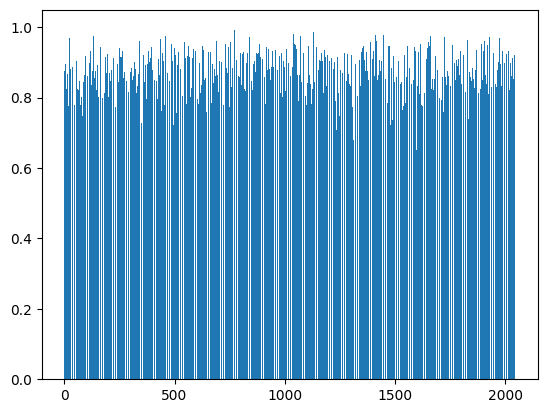

In [46]:
plt.bar(np.arange(len(values)), values)
plt.show()

In [47]:
preds = [unmapper[preds[i]] for i in range(len(preds))]
preds

['Mewtwo',
 'Snorlax',
 'Bulbasaur',
 'Poliwhirl',
 'Rattata',
 'Cloyster',
 'Shellder',
 'Slowbro',
 'Seel',
 'Dodrio',
 'Clefairy',
 'Sandslash',
 'Poliwhirl',
 'Ninetales',
 'Articuno',
 'Venusaur',
 'Venusaur',
 'Rhydon',
 'Porygon',
 'Grimer',
 'Pidgeot',
 'Dragonair',
 'Haunter',
 'Hypno',
 'Vaporeon',
 'Venusaur',
 'Seadra',
 'Venusaur',
 'Nidorino',
 'Beedrill',
 'Gyarados',
 'Fearow',
 'Zapdos',
 'Seadra',
 'Paras',
 'Mew',
 'Lickitung',
 'Magnemite',
 'Jynx',
 'Spearow',
 'Eevee',
 'Rhyhorn',
 'Dratini',
 'Machop',
 'Charmeleon',
 'Metapod',
 'Voltorb',
 'Persian',
 'Koffing',
 'Weedle',
 'Omanyte',
 'Porygon',
 'Ivysaur',
 'Seel',
 'Pinsir',
 'Charizard',
 'Chansey',
 'Exeggcute',
 'Charmeleon',
 'Zapdos',
 'Nidoking',
 'Dragonite',
 'Pinsir',
 'Growlithe',
 'Aerodactyl',
 'Farfetchd',
 'Tentacruel',
 'Poliwag',
 'MrMime',
 'Drowzee',
 'Charmander',
 'Rhydon',
 'Charmeleon',
 'Poliwhirl',
 'Lapras',
 'Articuno',
 'Charmeleon',
 'Weepinbell',
 'Dewgong',
 'Meowth',
 'Oddish',

In [50]:
submission_csv_path = '/AkhmetzyanovD/projects/MTS/NN/contest_1/nn-image/test.csv'
submission = pd.read_csv(submission_csv_path)
submission['label'] = preds
submission['cos'] = values
submission

,filename,label,cos
0,c329da38f8f9936f5d73e0391344eb5b4ebed8f6e9032f...,Mewtwo,0.975683
1,ac4919b1ff10b17d72c4645458ea3219384ffad641366b...,Snorlax,0.874535
2,eb277c6ebec8c7d075e518c0963f252d167f22eb6d164d...,Bulbasaur,0.886067
3,8cf03fbfc7b279e445006490be962dc414c19972bf7c94...,Poliwhirl,0.798457
4,e6bad7f867a11b24754eadd590392cf8fd0c2205569254...,Rattata,0.861316
...,...,...,...
2041,af41705187e351f183c57fd0b301f308cda474187c1f24...,Vaporeon,0.974591
2042,db980ce3e47a07e7a7fd538dfbf062446be49489973ccb...,Pidgey,0.921471
2043,61f1f9cb0e453cf02be0d19f8e533e825f574128150637...,Rattata,0.817931
2044,84e6e689f96be70b78e8576c2777e35a22f88736e09c62...,Kangaskhan,0.942584


In [51]:
submission.to_csv('/AkhmetzyanovD/projects/MTS/NN/contest_1/results/clip_cos/submission.csv', index=False)